<img src="images/satrday-cover.png" width="700">


### George Mount
### Stringfest Analytics
### [stringfestanalytics.com](https://georgejmount.com)

# Objectives for today

- Why "R-Powered Excel?"
- A tour of the landscape
- Write a formatted data frame, plot and regression results to a workbook
- Resources for future learning

# Follow along!

Run this notebook on Binder at the [GitHub repo](https://github.com/stringfestdata/satrday-r-powered-excel)

## R, Excel and the "data analytics stack"


<img src="images/data-analytics-stack.png" width="400">


Source: ["The Data Products Venn Diagram," Data Community DC](https://www.datacommunitydc.org/blog/2013/09/the-data-products-venn-diagram)

# CRAN does not disappoint for R/Excel interfaces:

- `gdata` (Perl required)
- `readxl` 
- `openxlsx` 
- `writexls` (Perl required)
- `XlConnect` (rJava required)
- `xlsx` (rJava required)
- `excel.link`
- etc...


## For most features with fewest external dependencies go with...

- `readxl`: A *read-only* Excel package from the `tidyverse`
- `openxlsx`: Full-service "R-powered Excel"  (The focus of this workshop)

# The basic workflow:

- Create a blank workbook with `createWorkbook()`
- Add worksheets with `addWorksheet()`
- Add various data frames, plots, summaries, etc.
- Save workbook with `saveWorkbook()`

Let's give it a spin with the `mpg` dataset:

In [1]:
# To interface with Excel
library(openxlsx)
# For data manipulation & visualization
library(tidyverse)
# For "tidying" regression output
library(broom)

mpg = read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv')

head(mpg)

Warning message:
"package 'openxlsx' was built under R version 4.0.3"
Warning message:
"package 'tidyverse' was built under R version 4.0.3"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

Warning message:
"package 'tibble' was built under R version 4.0.3"
Warning message:
"package 'readr' was built under R version 4.0.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'broom' was built under R version 4.0.3"

-- Column specification ------------------------------------------------------------------------------------------------
cols(
  mpg = col_double(),
  cylinders = col_double(),
  displacemen

mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
18,8,307,130,3504,12.0,70,usa,chevrolet chevelle malibu
15,8,350,165,3693,11.5,70,usa,buick skylark 320
18,8,318,150,3436,11.0,70,usa,plymouth satellite
16,8,304,150,3433,12.0,70,usa,amc rebel sst
17,8,302,140,3449,10.5,70,usa,ford torino
15,8,429,198,4341,10.0,70,usa,ford galaxie 500


### The `data` worksheet

First we'll set up objects referring to our workbook and worksheet, respectively. 

In [2]:
# Add workbook
wb <- createWorkbook()

# Add worksheet of raw data
data_sheet <- addWorksheet(wb, sheetName = 'data')

Next, we'll use the `writeDataTable()` function to write `mpg` to this worksheet as an Excel table. 

In [3]:
# Exclude row names
writeDataTable(wb, sheet = data_sheet, x = mpg, rowNames = FALSE)

Pretty much anything you could do to a workbook from Excel, you can do from `openxlsx`. 

For example, let's apply conditional formatting to the `name` column for observations starting with the phrase `ford`:

In [4]:
# Create conditional formatting style
fordStyle <- createStyle(fontColour = "#006100", bgFill = "#C6EFCE")

conditionalFormatting(wb, sheet = data_sheet, 
                  # Find the index position of weight
                  cols = which(colnames(mpg) == 'name'),
                  # Format from rows 2 through the end of mpg (account for header)
                  rows = 2:(nrow(mpg) + 1),
                  # What type of rule is this?
                  type = 'beginsWith',
                  # What is the rule?
                  rule = 'ford',
                  # Apply style
                  style = fordStyle)

### The `analysis` worksheet

I would also like to include an `analysis` worksheet including regression results and a scatterplot of the relationship between `mpg` and `weight`. 

We can set up a new worksheet, add the results of the regression with `writeData()` and add the scatterplot with `writePlot()` 

In [7]:
# Set up a new worksheet 
analysis_sheet <- addWorksheet(wb, sheetName = 'analysis')

In [8]:
# Build a tidy lm regression output
mpg_lm <- lm(mpg ~ weight, data = mpg)
mpg_lm_tidy  <-  tidy(mpg_lm)

mpg_lm_tidy

# Add the table to this worksheet
writeDataTable(wb, sheet = analysis_sheet, x = mpg_lm_tidy, rowNames = FALSE)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),46.31736442,0.7952452295,58.24287,2.753438e-196
weight,-0.00767661,0.0002574869,-29.81360,2.972800e-103


`geom_smooth()` using formula 'y ~ x'



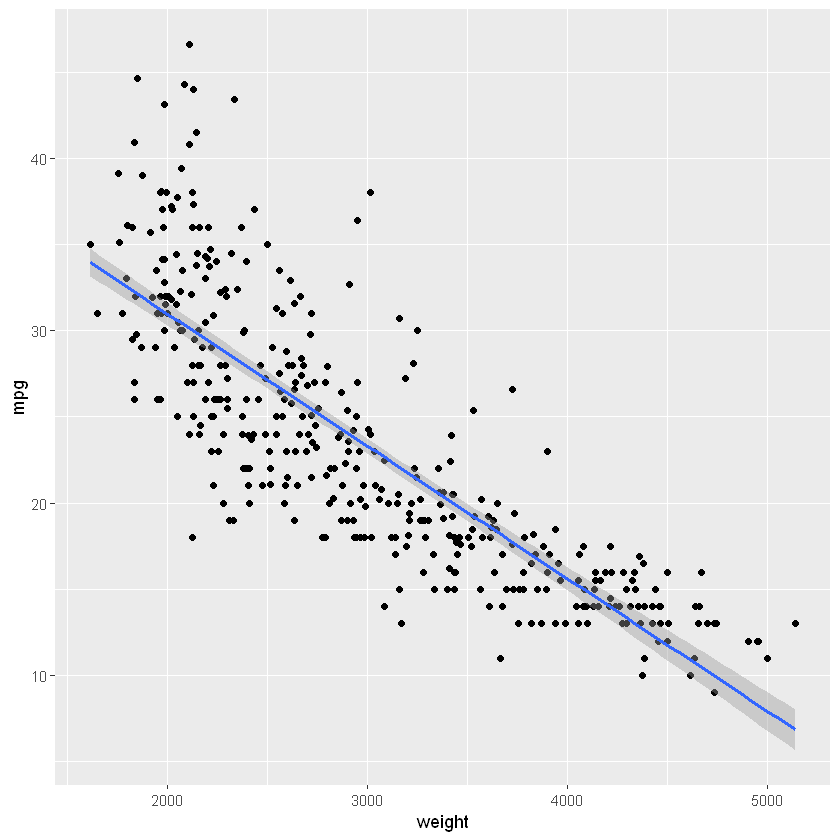

In [9]:
# Visualize the results
ggplot(data = mpg, aes(x = weight, y = mpg))+
    geom_point()+
    geom_smooth(method = 'lm')

# Add the image to the worksheet, set the placement
insertPlot(wb, sheet = analysis_sheet, startRow = 5, startCol = "A", width = 4, height = 4)

### Admire our work, part 1

OK, let's save and view our work. By default, `saveWorkbook()` will put the file in our working directory.

Let's take a look at the finished output in Excel.

In [10]:
mpg_report = 'mpg-report.xlsx'

# save workbook to working directory
saveWorkbook(wb = wb, file = mpg_report, overwrite = TRUE)

It's pretty good! But as a matter of fact I would like to do a few more things to the workbook:

- Freeze panes in each worksheet
- Autofit the column widths in each worksheet
- Format the `weight` column in thousands and `acceleration` with a decimal in the `data` worksheet. 

The connection from R to our workbook is still open in our session; as long as our workbook remains closed, these additinoal changes will be applied to the workbook.

Let's give it a go:

In [11]:
for (sheet in getSheetNames(mpg_report)){
    freezePane(wb, sheet = sheet, firstRow = TRUE)
}

In [12]:
thousands <- createStyle(numFmt = "#,##0")

addStyle(wb, sheet = data_sheet, style = thousands, cols = which(colnames(mpg) == 'weight'), rows = 1:nrow(mpg))

In [13]:
setColWidths(wb, sheet = data_sheet, cols = ncol(mpg), widths = "auto")

Let's try this again!

This time, let's use `openXL()` to launch the workbook directly from R.

In [14]:
mpg_report = 'mpg-report.xlsx'

saveWorkbook(wb = wb, file = mpg_report, overwrite = TRUE)

openXL(mpg_report)

### Encore: write to multiple workbooks

Finally, we can write to multiple worksheets by splitting our data frame into a list based on the `origin` variable. We'll then write each data frame in the list to its own workbook.

<font color='gray'>*This is my "loopy" base R way of doing it; suggestions for improvement welcome!*</font>

In [6]:
mpg_split <- split(mpg, mpg$origin)
mpg_split

mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
26,4,97,46,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
25,4,110,87,2672,17.5,70,europe,peugeot 504
24,4,107,90,2430,14.5,70,europe,audi 100 ls
25,4,104,95,2375,17.5,70,europe,saab 99e
26,4,121,113,2234,12.5,70,europe,bmw 2002
28,4,116,90,2123,14.0,71,europe,opel 1900
30,4,79,70,2074,19.5,71,europe,peugeot 304
30,4,88,76,2065,14.5,71,europe,fiat 124b
27,4,97,60,1834,19.0,71,europe,volkswagen model 111


In [17]:
# Check the home directory for these files
ws_counter <- 1

for(ws in mpg_split){
  write.xlsx(ws, file = paste0(names(mpg_split)[ws_counter],'.xlsx'), asTable = TRUE)
  ws_counter <- ws_counter + 1} 

In [18]:
split(mpg, mpg$origin) %>%
  map(~ write_csv(., file = paste0(.,'.xlsx')))

Warning message in file(con, "wb"):
"cannot open file 'c(26, 25, 24, 25, 26, 28, 30, 30, 27, 23, 18, 22, 21, 26, 26, 26, 29, 24, 20, 19, 24, 29, 26, 26, 24, 26, 31, 25, 29, 23, 23, 22, 25, 28, 25, 27, 29, 29.5, 20, 19, 16.5, 36, 29, 30.5, 21.5, 43.1, 20.3, 17, 21.6, 16.2, 31.5, 31.9, 25.4, 27.2, 37.3, 41.5, 34.3, 44.3, 43.4, 36.4, 30, 40.9, 29.8, 35, 33, 34.5, 28.1, 30.7, 36, 44).xlsx
c(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 6, 4, 6, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4).xlsx
c(97, 110, 107, 104, 121, 116, 79, 88, 97, 97, 121, 121, 120, 96, 97, 98, 68, 116, 114, 121, 121, 98, 79, 97, 90, 116, 79, 90, 90, 115, 120, 121, 121, 107, 116, 101, 90, 97, 130, 120, 168, 79, 97, 97, 121, 90, 131, 163, 121, 163, 89, 89, 183, 141, 91, 98, 97, 90, 90, 121, 146, 85, 89, 122, 105, 100, 141, 145, 105, 97).xlsx
c(46, 87, 90, 95, 113, 90, 70, 76, 60, 54, 112, 76, 87, 69, 46, 90, 49

ERROR: Error in file(con, "wb"): cannot open the connection


Warning message in file(con, "wb"):
"cannot open file 'c(24, 27, 27, 25, 31, 35, 24, 19, 28, 23, 27, 20, 22, 18, 20, 31, 32, 31, 32, 24, 26, 29, 24, 24, 33, 33, 32, 28, 19, 31.5, 33.5, 26, 30, 22, 21.5, 32.8, 39.4, 36.1, 27.5, 27.2, 21.1, 23.9, 29.5, 34.1, 31.8, 38.1, 37.2, 29.8, 31.3, 37, 32.2, 46.6, 40.8, 44.6, 33.8, 32.7, 23.7, 32.4, 39.1, 35.1, 32.3, 37, 37.7, 34.1, 33.7, 32.4, 32.9, 31.6, 25.4, 24.2, 37, 31, 36, 36, 34, 38, 32, 38, 32).xlsx
c(4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4).xlsx
c(113, 97, 97, 113, 71, 72, 113, 70, 97, 120, 97, 97, 108, 70, 156, 79, 71, 76, 83, 120, 108, 97, 134, 119, 91, 91, 85, 97, 156, 98, 85, 97, 97, 146, 80, 78, 85, 91, 134, 119, 134, 119, 98, 86, 85, 89, 86, 134, 120, 119, 108, 86, 85, 91, 97, 168, 70, 107, 79, 81, 97, 85, 89, 91, 107, 108, 119, 120, 168, 1

ERROR: Error in file(con, "wb"): cannot open the connection


Warning message in file(con, "wb"):
"cannot open file 'c(18, 15, 18, 16, 17, 15, 14, 14, 14, 15, 15, 14, 15, 14, 22, 18, 21, 21, 10, 10, 11, 9, 28, 25, 19, 16, 17, 19, 18, 14, 14, 14, 14, 12, 13, 13, 18, 22, 19, 18, 23, 26, 25, 20, 21, 13, 14, 15, 14, 17, 11, 13, 12, 13, 15, 13, 13, 14, 22, 28, 13, 14, 13, 14, 15, 12, 13, 13, 14, 13, 12, 13, 18, 16, 18, 18, 23, 11, 12, 13, 12, 18, 21, 19, 21, 15, 16, 15, 11, 20, 21, 19, 15, 26, 25, 16, 16, 18, 16, 13, 14, 14, 14, 28, 19, 18, 15, 15, 16, 15, 16, 14, 17, 16, 15, 18, 21, 20, 13, 23, 20, 23, 18, 19, 25, 
26, 17.5, 16, 15.5, 14.5, 22, 22, 24, 22.5, 29, 24.5, 20, 18, 18.5, 17.5, 26.5, 13, 16.5, 13, 13, 13, 30, 25.5, 17.5, 17, 15.5, 15, 17.5, 20.5, 19, 18.5, 16, 15.5, 15.5, 16, 24.5, 25.5, 30.5, 33.5, 36.1, 19.9, 19.4, 20.2, 19.2, 20.5, 20.2, 25.1, 20.5, 19.4, 20.6, 20.8, 18.6, 18.1, 19.2, 17.7, 18.1, 17.5, 30, 30.9, 23.2, 23.8, 21.5, 19.8, 22.3, 20.2, 20.6, 17, 17.6, 16.5, 18.2, 16.9, 15.5, 19.2, 18.5, 35.7, 27.4, 23, 23.9, 34.2, 34.5, 28.4,

ERROR: Error in file(con, "wb"): cannot open the connection


Warning message in file(con, "wb"):
"cannot open file 'c(18, 15, 18, 16, 17, 15, 14, 14, 14, 15, 15, 14, 15, 14, 22, 18, 21, 21, 10, 10, 11, 9, 28, 25, 19, 16, 17, 19, 18, 14, 14, 14, 14, 12, 13, 13, 18, 22, 19, 18, 23, 26, 25, 20, 21, 13, 14, 15, 14, 17, 11, 13, 12, 13, 15, 13, 13, 14, 22, 28, 13, 14, 13, 14, 15, 12, 13, 13, 14, 13, 12, 13, 18, 16, 18, 18, 23, 11, 12, 13, 12, 18, 21, 19, 21, 15, 16, 15, 11, 20, 21, 19, 15, 26, 25, 16, 16, 18, 16, 13, 14, 14, 14, 28, 19, 18, 15, 15, 16, 15, 16, 14, 17, 16, 15, 18, 21, 20, 13, 23, 20, 23, 18, 19, 25, 
26, 17.5, 16, 15.5, 14.5, 22, 22, 24, 22.5, 29, 24.5, 20, 18, 18.5, 17.5, 26.5, 13, 16.5, 13, 13, 13, 30, 25.5, 17.5, 17, 15.5, 15, 17.5, 20.5, 19, 18.5, 16, 15.5, 15.5, 16, 24.5, 25.5, 30.5, 33.5, 36.1, 19.9, 19.4, 20.2, 19.2, 20.5, 20.2, 25.1, 20.5, 19.4, 20.6, 20.8, 18.6, 18.1, 19.2, 17.7, 18.1, 17.5, 30, 30.9, 23.2, 23.8, 21.5, 19.8, 22.3, 20.2, 20.6, 17, 17.6, 16.5, 18.2, 16.9, 15.5, 19.2, 18.5, 35.7, 27.4, 23, 23.9, 34.2, 34.5, 28.4,

ERROR: Error in file(con, "wb"): cannot open the connection


mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
26,4,97,46,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
25,4,110,87,2672,17.5,70,europe,peugeot 504
24,4,107,90,2430,14.5,70,europe,audi 100 ls
25,4,104,95,2375,17.5,70,europe,saab 99e
26,4,121,113,2234,12.5,70,europe,bmw 2002
28,4,116,90,2123,14.0,71,europe,opel 1900
30,4,79,70,2074,19.5,71,europe,peugeot 304
30,4,88,76,2065,14.5,71,europe,fiat 124b
27,4,97,60,1834,19.0,71,europe,volkswagen model 111


In [16]:
getwd()

[1] "C:/Users/User/Documents/GitHub/satrday-r-powered-excel"

In [19]:
# https://luisdva.github.io/rstats/export-iteratively/
# load libraries
library(dplyr)  
library(purrr)
library(tidyr)
library(readr)

# read csv from web
batRecs <- read.csv("https://raw.githubusercontent.com/luisDVA/codeluis/master/batRecords.csv",stringsAsFactors = FALSE)

# preview how many files we should be ending up with
batRecs %>% count(family)


# drop na, split, remove duplicates, write to disk
batRecs %>%  drop_na() %>% 
  group_by(family) %>% group_map(~distinct(.x,decimal_latitude,decimal_longitude,.keep_all=TRUE),keep = TRUE) %>% 
  walk(~.x %>%  write.xlsx(., path = paste0("dec_",unique(.x$family),".csv")))

family,n
<chr>,<int>
Emballonuridae,18
Molossidae,39
Mormoopidae,21
Phyllostomidae,263
Vespertilionidae,59


Warning message:
"The `keep` argument of `group_map()` is deprecated as of dplyr 1.0.0.
Please use the `.keep` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."
Warning message:
"The `path` argument of `write_csv()` is deprecated as of readr 1.4.0.
Please use the `file` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


In [20]:
head(batRecs)

,order,family,sp,occurrence_id,decimal_latitude,decimal_longitude
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Chiroptera,Phyllostomidae,Artibeus jamaicensis,FCIE:MZFC-M:0388,16.76583,-98.72000
2,Chiroptera,Vespertilionidae,Lasiurus cinereus,FCIE:MZFC-M:5693,18.97528,-99.34028
3,Chiroptera,Phyllostomidae,Artibeus aztecus,FCIE:MZFC-M:4225,18.60694,-99.60667
4,Chiroptera,Molossidae,Tadarida brasiliensis,FCIE:MZFC-M:6271,24.31667,-99.06667
5,Chiroptera,Molossidae,Molossus rufus,FCIE:MZFC-M:0988,17.21639,-100.43361
6,Chiroptera,Phyllostomidae,Dermanura phaeotis,FCIE:MZFC-M:7122,16.90097,-90.96939


# Questions?

# Recommended resources:  



## 1. `browseVignettes()`

In [18]:
# This takes a while to run in Jupyter...
browseVignettes(package = c('readxl', 'openxlsx'))

starting httpd help server ...
 done



## 2. [R & Excel -- LondonR meetup presentation by UBS analysts](https://www.londonr.org/wp-content/uploads/sites/2/presentations/LondonR_-_R_&_Excel_-_David_Jessop_-_20170713.pdf)


![UBS R Excel](images/ubs-r-excel.png)

## 3. In case you're interested in running R on Jupyter:

- Download `IRkernel` package from CRAN ([instructions here](https://irkernel.github.io/installation/))

## 4. In case you're interested in running R on Binder:

- You need a `runtime.txt` file and optionally an `install.R` file
- [Full instructions here](https://github.com/binder-examples/r)

# THANK YOU

### George Mount
### Stringfest Analytics
### [stringfestanalytics.com](https://georgejmount.com)
### [linkedin.com/in/gjmount](https://www.linkedin.com/in/gjmount/)
